<a href="https://colab.research.google.com/github/Somdyuti159/COVID-19_X-Ray_Detection/blob/main/Covid_Chest_Xray_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Creating/Organizing the dataset

#### Skip if dataset.zip exists

In [ ]:
import os
import pandas as pd
from shutil import copy
from sklearn.model_selection import train_test_split

In [ ]:
# Create a dataset folder in colab

if not os.path.exists('dataset'):
    os.mkdir('dataset')
    os.mkdir('dataset/Positive')
    os.mkdir('dataset/Negative')

    os.mkdir('dataset/train')
    os.mkdir('dataset/test')
    os.mkdir('dataset/train/Positive')
    os.mkdir('dataset/train/Negative')
    os.mkdir('dataset/test/Positive')
    os.mkdir('dataset/test/Negative')

In [ ]:
# Copy the COVID-19 images to the dataset folder here

FILE_PATH = 'drive/My Drive/Covid/metadata.csv'
IMAGES_PATH = 'drive/My Drive/Covid/images/'

df = pd.read_csv(FILE_PATH)
for i, row in df.iterrows():
    if 'COVID-19' in row['finding'] and row['view'] == 'PA':
        img = IMAGES_PATH + row['filename']
        copy(img, f'dataset/Positive/{row["filename"]}')

len(os.listdir('dataset/Positive'))

In [ ]:
# Copy the Normal images

# choose around the same number of images to maintain balance in the dataset
from random import sample

NORMAL_PATH = 'drive/My Drive/Normal/'
choices = sample(os.listdir(NORMAL_PATH), 200)

for img in choices:
    copy(NORMAL_PATH + img, f'dataset/Negative/{img}')

In [ ]:
# Create a train and a test set

data = [f'Positive/{i}' for i in os.listdir('dataset/Positive')]
data += [f'Negative/{i}' for i in os.listdir('dataset/Negative')]

train, test = train_test_split(data, test_size=0.1)

[copy(f'dataset/{i}', f'dataset/train/{i}') for i in train]
[copy(f'dataset/{i}', f'dataset/test/{i}') for i in test]

len(train), len(test)

In [ ]:
# remove the positive and the negative folder from dataset
! rm -rf dataset/Positive
! rm -rf dataset/Negative

# Create a zip folder of the dataset for later use
! zip -r dataset.zip dataset/

# copy the zip to drive
! cp dataset.zip drive/My\ Drive/Covid-Clf/

# Getting the dataset from drive

In [ ]:
%%sh

cp drive/My\ Drive/Covid-Clf/dataset.zip /content/
unzip -q dataset.zip

# Model generation

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, Flatten, AveragePooling2D

In [ ]:
base = DenseNet121(include_top=False, input_shape=(224, 224, 3))
for layer in base.layers[:-3]: layer.trainable = False

model = Sequential(
    [
        base,
        AveragePooling2D((4, 4)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', AUC()])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 7,103,169
Trainable params: 67,713
Non-trainable params: 7,035,456
_______________________________________

# Setting up HyperParameters

In [ ]:
BATCH_SIZE = 8
N_EPOCHS = 8

# Creating the Image generators for the model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.1
)

train_data = datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
)

valid_data = datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_data = datagen.flow_from_directory(
    'dataset/test',
    target_size=(224, 224),
    class_mode='binary'
)

Found 321 images belonging to 2 classes.
Found 35 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


# Training the model

In [ ]:
# # test untrained model on the test set

loss, acc, auc = model.evaluate(test_data)

print(
    f'''
Test Evaluation results (Untrained):

Loss = {loss:.2f}
Accuracy = {acc * 100:.2f} %
AUC = {auc:.2f}'''
)


2/2 [==============================] - 1s 390ms/step - loss: 0.7792 - acc: 0.5250 - auc_1: 0.7130

Test Evaluation results (Untrained):

Loss = 0.78
Accuracy = 52.50 %
AUC = 0.71


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

chkpt = ModelCheckpoint(
    'best-model/best_ckpt', 
    monitor='val_acc',
    save_weights_only=True,
    save_best_only=True
)

In [ ]:
hist = model.fit(
    train_data, epochs=N_EPOCHS, 
    validation_data=valid_data, 
    callbacks=[chkpt]
)

Epoch 1/8
41/41 [==============================] - 36s 883ms/step - loss: 0.3992 - acc: 0.8442 - auc_1: 0.9095 - val_loss: 0.2273 - val_acc: 0.8571 - val_auc_1: 0.9706
Epoch 2/8
41/41 [==============================] - 37s 901ms/step - loss: 0.2014 - acc: 0.9128 - auc_1: 0.9746 - val_loss: 0.2106 - val_acc: 0.9143 - val_auc_1: 0.9869
Epoch 3/8
41/41 [==============================] - 36s 890ms/step - loss: 0.1317 - acc: 0.9564 - auc_1: 0.9880 - val_loss: 0.1638 - val_acc: 0.9429 - val_auc_1: 0.9935
Epoch 4/8
41/41 [==============================] - 36s 885ms/step - loss: 0.1622 - acc: 0.9377 - auc_1: 0.9819 - val_loss: 0.1075 - val_acc: 0.9714 - val_auc_1: 0.9902
Epoch 5/8
41/41 [==============================] - 32s 776ms/step - loss: 0.1222 - acc: 0.9533 - auc_1: 0.9909 - val_loss: 0.0953 - val_acc: 0.9714 - val_auc_1: 0.9967
Epoch 6/8
41/41 [==============================] - 29s 706ms/step - loss: 0.1018 - acc: 0.9657 - auc_1: 0.9932 - val_loss: 0.0887 - val_acc: 0.9714 - val_auc_1:

#### Loss curves

In [ ]:
import matplotlib.pyplot as plt 

X = range(N_EPOCHS)


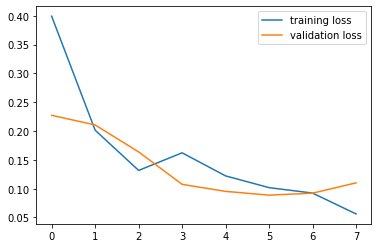

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(X, loss, label='training loss')
plt.plot(X, val_loss, label='validation loss')
plt.legend()
plt.show()

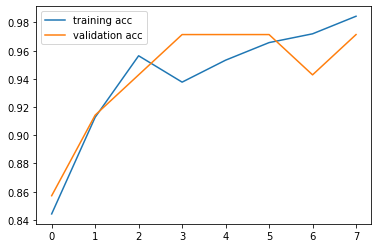

In [ ]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(X, acc, label='training acc')
plt.plot(X, val_acc, label='validation acc')
plt.legend()
plt.show()

# Evaluating the model's performance

In [ ]:
model.load_weights('best-model/best_ckpt')

In [ ]:
loss, acc, auc = model.evaluate(test_data)

print(
    f'''
Test Evaluation results:

Loss = {loss:.2f}
Accuracy = {acc * 100:.2f} %
AUC = {auc:.2f}'''
)

2/2 [==============================] - 1s 312ms/step - loss: 0.0883 - acc: 0.9750 - auc_1: 1.0000

Test Evaluation results:

Loss = 0.09
Accuracy = 97.50 %
AUC = 1.00


In [ ]:
model.save('covid_model.h5')

# Testing model on individual images

In [ ]:
#use this if you're running just the model

# from tensorflow.keras.models import load_model
# model = load_model('test_model.h5')

In [ ]:
import cv2
import numpy as np

In [ ]:
def preprocess_image(img_path):
    img = cv2.cvtColor(cv2.resize(cv2.imread(img_path), (224, 224)), cv2.COLOR_BGR2RGB)
    return img[np.newaxis, ...] / 255 

In [ ]:
import os

In [ ]:
def predict_covid(img):
    inp = preprocess_image(img)
    if model.predict(inp) > 0.75: return 'Positive'
    return 'Negative'

In [ ]:
predict_covid('dataset/test/Positive/2-chest-filmc.jpg')

'Positive'

In [ ]:
predict_covid('dataset/test/Negative/NORMAL2-IM-1300-0001.jpeg')

'Negative'